In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas
import rasterio

from sklearn import metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch

class_name = 'prehistoric'
asc_folder_path = 'asc/*.asc'
pts_path = 'shp/Prehistoric_value_v1.shp'

In [2]:
# Extract env rasters values such as, 
#    grid size  (grid_size) 
#    number of rows (Nrow_y)
#    number of columns  (Ncol_x) 
#    left(west) most corner in longtitude   (y_left_lower_corner) 
#    bottom(south) corner in latitude   (x_left_lower_corner = []) 
#    coverages  (coverages)   

def prepare_env_asc_data(asc_folder_path):
    grid_size=[] 
    Nrow_y=[]
    Ncol_x = [] 
    y_left_lower_corner = [] 
    x_left_lower_corner = [] 
    coverages = []

    for asc in glob.glob(asc_folder_path):
        raster = rasterio.open(asc)
        
        grid_size.append(raster.meta['transform'][0])
        Nrow_y.append(raster.meta['height'])
        Ncol_x.append(raster.meta['width'])
        y_left_lower_corner.append(raster.bounds[1])
        x_left_lower_corner.append(raster.bounds[0])
        coverages.append(raster.read()[0])
    
    # check if the values except coverages are matching
    # if not may require reviewing outside this script   
    if len(set(grid_size))!=1 or len(set(Nrow_y))!=1 or len(set(Ncol_x))!=1 or len(set(y_left_lower_corner))!=1 or len(set(x_left_lower_corner))!=1:
        print('!! Warning Env rasters are not matching !!')
        return None
    else:
        print('- env_data prepared successfully')
        data = dict(grid_size= grid_size[0], 
                    Nrow_y= Nrow_y[0], 
                    Ncol_x = Ncol_x[0], 
                    y_left_lower_corner = y_left_lower_corner[0], 
                    x_left_lower_corner = x_left_lower_corner[0], 
                    coverages = np.array(coverages))
        return data

# Preview env_data
#env_data = prepare_env_asc_data(asc_folder_path=asc_folder_path)
#for i in env_data:
#    print(env_data[i])

In [3]:
# Prepare archaeological presence data points for train test split
def prepare_presence_point_data(pts_path, x_long_colname, y_lat_colname, define_class_value):
    points = geopandas.read_file(pts_path)
        
    points = points.loc[:,[x_long_colname, y_lat_colname]]
    points["class"] = define_class_value
    
    points_train, points_test = train_test_split(points, train_size=0.5)

    points_train = points_train.to_records(index=False, column_dtypes={'X': '<f4', 'Y': '<f4', 'class': 'S22'})
    points_test = points_test.to_records(index=False, column_dtypes={'X': '<f4', 'Y': '<f4', 'class': 'S22'})

    pts_data = dict(train=points_train, test=points_test)

    print('- pts_data prepared successfully')
    return pts_data

# Preview pts_data
#pts_data = prepare_presence_point_data(pts_path=pts_path, x_long_colname="X", y_lat_colname="Y", define_class_value=class_name)
#print(pts_data['train'])
#print(len(pts_data['train']), len(pts_data['test']))
    

In [4]:
# Construct the map grid from the batch object
def construct_grids(data):
    # x,y coordinates for corner cells
    xmin = data['x_left_lower_corner'] + data['grid_size']
    xmax = xmin + (data['Ncol_x'] * data['grid_size'])
    ymin = data['y_left_lower_corner'] + data['grid_size']
    ymax = ymin + (data['Nrow_y'] * data['grid_size'])

    # x coordinates of the grid cells
    xgrid = np.arange(xmin, xmax, data['grid_size'])
    # y coordinates of the grid cells
    ygrid = np.arange(ymin, ymax, data['grid_size'])

    print('- x, y grid constructed successfully')
    return xgrid, ygrid

# Preview xgrid, ygrid
#xgrid, ygrid = construct_grids(data=env_data)
#print(xgrid.shape)
#print(ygrid.shape)

In [5]:
def create_archaeology_bunch(class_name, train, test, coverages, xgrid, ygrid):
    """Create a bunch with information

    This will use the test/train record arrays to extract the
    data specific to the given archaeology class.
    """
    bunch = Bunch(name=" ".join(class_name.split("_")[:2]))
    class_name = class_name.encode("ascii")
    points = dict(test=test, train=train)

    for label, pts in points.items():
        # choose points associated with the desired species
        pts = pts[pts["class"] == class_name]
        bunch["pts_%s" % label] = pts
        #print(bunch["pts_%s" % label])

        # determine coverage values for each of the training & testing points
        ix = np.searchsorted(xgrid, pts["X"])
        iy = np.searchsorted(ygrid, pts["Y"])
        bunch["cov_%s" % label] = coverages[:, -iy, ix].T

    print('- bunch created successfully')
    return bunch

# Preview prehistoric_bunch
#prehistoric_bunch = create_archaeology_bunch(class_name=class_name, train=pts_data['train'], test=pts_data['test'], coverages=env_data['coverages'], xgrid=xgrid, ygrid=ygrid)
#for i in prehistoric_bunch:
#    print(prehistoric_bunch)

In [6]:
def plot_prediction(env_data, pts_data, class_name):

    # Set up the data grid
    xgrid, ygrid = construct_grids(data=env_data)

    # The grid in x,y coordinates
    X, Y = np.meshgrid(xgrid, ygrid[::-1])
    
    # create bunch
    prehistoric_bunch = create_archaeology_bunch(class_name=class_name, 
                                                 train=pts_data['train'], 
                                                 test=pts_data['test'], 
                                                 coverages=env_data['coverages'], 
                                                 xgrid=xgrid, 
                                                 ygrid=ygrid)

    # take reference of coverages[1] to decide land and water. coverages[1] is the elevation raster. 
    land_reference = env_data['coverages'][0]
    
    # Fit, predict, and plot.
    print("_" * 80)
    print("Modeling distribution of species '%s'" % class_name)

    # Standardize features
    mean = prehistoric_bunch['cov_train'].mean(axis=0)
    std = prehistoric_bunch['cov_train'].std(axis=0)
    train_cover_std = (prehistoric_bunch['cov_train'] - mean) / std

    # Fit OneClassSVM
    print(" - fit OneClassSVM ... ", end="")
    clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.5)
    clf.fit(train_cover_std)
    print("done.")

    # Plot map
    print(" - plot coastlines from coverage... ", end="")
    plt.contour(
    X, Y, land_reference, levels=[-9998], colors="k", linestyles="solid"
    )
    print("done.")
    
    # Predict species distribution using the training data
    print(" - predict... ", end="")
    Z = np.ones((env_data['Nrow_y'], env_data['Ncol_x'],), dtype=np.float64)

    # Predict only for the land points
    idx = np.where(land_reference > -9999)
    coverages_land = env_data['coverages'][:, idx[0], idx[1]].T

    pred = clf.decision_function((coverages_land - mean) / std)
    Z *= pred.min()
    Z[idx[0], idx[1]] = pred

    levels = np.linspace(Z.min(), Z.max(), 25)
    Z[land_reference == -9999] = -9999
    print("done.")

    # plot contours of the prediction
    print(" - plot prediction... ", end="")
    plt.contourf(X, Y, Z, levels=levels, cmap='Greens')
    plt.colorbar(format="%.2f")

    # scatter training/testing points
    plt.scatter(
        pts_data['train']['X'],
        pts_data['train']['Y'],
        s=2**2,
        c="red",
        marker="^",
        label="train",
    )
    plt.scatter(
        pts_data['test']['X'],
        pts_data['test']['Y'],
        s=2**2,
        c="black",
        marker="x",
        label="test",
    )
    plt.legend()
    plt.title(class_name)
    plt.axis("equal")
    print("done.")

    # export prediction as raster
    # this method take reference of the input environemental raster
    print(" - create raster... ", end="")
    raster = rasterio.open(glob.glob(asc_folder_path)[0])
    new_dataset = rasterio.open(
        'SVM_result/svm.asc',
        'w',
        driver=raster.driver,
        height=raster.height,
        width=raster.width,
        count=raster.count,
        dtype=raster.meta['dtype'],
        crs=raster.crs,
        transform=raster.transform,
        nodata=raster.nodata
    )
    new_dataset.write(Z, 1)
    new_dataset.close()
    print("done.")

    # background points (grid coordinates) for evaluation
    print(" - compute AUC... ", end="")
    np.random.seed(13)
    background_points = np.c_[
        np.random.randint(low=0, high=env_data['Nrow_y'], size=10000),
        np.random.randint(low=0, high=env_data['Ncol_x'], size=10000),
    ].T

    # Compute AUC with regards to background points
    pred_background = Z[background_points[0], background_points[1]]
    pred_test = clf.decision_function((prehistoric_bunch['cov_test'] - mean) / std)
    scores = np.r_[pred_test, pred_background]
    y = np.r_[np.ones(pred_test.shape), np.zeros(pred_background.shape)]
    fpr, tpr, thresholds = metrics.roc_curve(y, scores)
    roc_auc = metrics.auc(fpr, tpr)
    print("done.")

    print("_" * 80)
    print("\n Area under the ROC curve : %f" % roc_auc)


- env_data prepared successfully
- pts_data prepared successfully
- x, y grid constructed successfully
- bunch created successfully
________________________________________________________________________________
Modeling distribution of species 'prehistoric'
 - fit OneClassSVM ... done.
 - plot coastlines from coverage... done.
 - predict... done.
 - plot prediction... done.
 - create raster... done.
 - compute AUC... done.
________________________________________________________________________________

 Area under the ROC curve : 0.879598


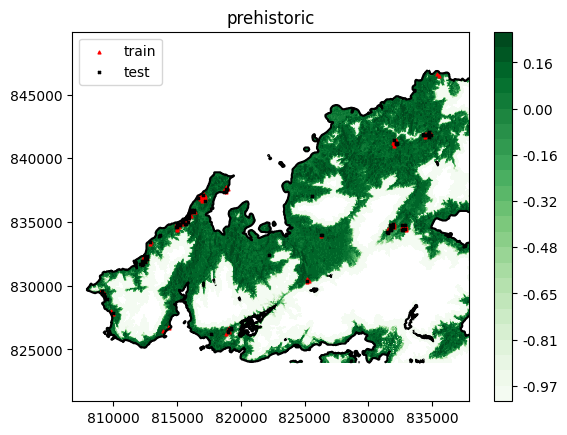

In [9]:
# Load data
env_data = prepare_env_asc_data(asc_folder_path=asc_folder_path)
pts_data = prepare_presence_point_data(pts_path=pts_path, x_long_colname="X", y_lat_colname="Y", define_class_value=class_name)

# Prediction
Z = plot_prediction(env_data=env_data, pts_data=pts_data, class_name=class_name)